In [1]:
# =============================================================================
# NOTEBOOK SETUP - Two Population Delay Sweep Execution
# =============================================================================
import os
import sys
from pathlib import Path
from brian2 import *


# Robust directory setup
if Path.cwd().name == 'two_populations':
    os.chdir("../../")

from src.two_populations.helpers.logger import setup_logger

logger = setup_logger(
    experiment_name="test_delays",
    console_level="DEBUG",
    log_to_file=False
)

restore_initial_state()

logger.info(f"Working directory: {Path.cwd()}")
logger.info(f"Python path: {sys.path[0]}")

/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(
INFO       Cache size for target 'cython': 2687 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/ubuntu-deduce/.cython/brian_extensions' directory. [brian2]
INFO     | __main__:<module>:24 - Working directory: /home/ubuntu-deduce/Projects/izhikevich
INFO     | __main__:<module>:25 - Python path: /home/ubuntu-deduce/.asdf/installs/python/3.10.13/lib/python310.zip


In [2]:
from src.two_populations.model import IzhikevichNetwork
import numpy as np
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results, print_network_statistics_table
from src.two_populations.plots.dashboard_plots import plot_connectivity_dashboard, plot_population_dashboard

# =============================================================================
# SINGLE SIMULATION CONFIGURATION
# =============================================================================

def run_iteration(NETWORK_PARAMS, SIM_CONFIG, trial=0, create_population_type='2'):
    
    logger.info("Simulation configured:")
    logger.info(f"  Duration: {SIM_CONFIG['T_ms']}ms, dt: {SIM_CONFIG['dt_ms']}ms")

    # =============================================================================
    # RUN SINGLE SIMULATION
    # =============================================================================

    start_scope()

    # Create network
    network = IzhikevichNetwork(
        dt_val=SIM_CONFIG['dt_ms'],
        T_total=SIM_CONFIG['T_ms'],
        fixed_seed=100 + trial*3,
        variable_seed=200 + trial*3,
        trial=trial
    )

    if create_population_type == '1':

        pop_A = network.create_population(name='A', **NETWORK_PARAMS['pop_A'])
        
    else:
        
        pop_A = network.create_population2(name='A', **NETWORK_PARAMS['pop_A'])
    # Caso 1: Silencio + pulso de 50ms
    # pop_A = network.create_population('A', **NETWORK_PARAMS['pop_A'])


    # Setup monitors and run
    network.setup_monitors(['A'], record_v_dt=0.1, sample_fraction=0.2)
    results = network.run_simulation()

    # Quick check
    logger.info(f"\n{'='*50}")
    logger.info("SIMULATION COMPLETED")
    logger.info(f"{'='*50}")
    logger.info(f"Population A: {len(results['A']['spike_times'])} spikes")
    logger.info(f"Recording shape: {results['A']['potentials'].shape}")

    return results, network, SIM_CONFIG

In [3]:
"""
Balance E/I Optimizer - Versión Paralelizada
=============================================

Estrategias de paralelización:
1. Nivel 1 (IMPLEMENTADO): Paralelizar los 10 trials independientes
2. Nivel 2 (OPCIONAL): Paralelizar evaluaciones dentro de cada trial

Mejoras adicionales:
- Funciones auxiliares optimizadas
- Gestión eficiente de memoria
- Logging estructurado
"""

import numpy as np
import multiprocessing as mp
from functools import partial
from datetime import datetime
import time


# =============================================================================
# FUNCIONES AUXILIARES OPTIMIZADAS
# =============================================================================

def analyze_ei_balance(network, pop_name='A', N_exc=800, N_inh=200):
    """
    Analiza balance E/I (versión optimizada con numpy vectorizado).
    """
    syn_intra = network.populations[pop_name]['syn_intra']
    
    # Extraer arrays una sola vez
    pre_idx = np.array(syn_intra.i)
    post_idx = np.array(syn_intra.j)
    weights = np.array(syn_intra.w)
    
    N_total = N_exc + N_inh
    
    # Máscara booleana para neuronas excitatorias
    is_exc_pre = pre_idx < N_exc
    
    # Inicializar acumuladores
    I_exc_received = np.zeros(N_total)
    I_inh_received = np.zeros(N_total)
    n_exc_inputs = np.zeros(N_total, dtype=int)
    n_inh_inputs = np.zeros(N_total, dtype=int)
    
    # Acumulación vectorizada usando np.add.at (más eficiente que loop)
    exc_mask = is_exc_pre
    inh_mask = ~is_exc_pre
    
    np.add.at(I_exc_received, post_idx[exc_mask], weights[exc_mask])
    np.add.at(I_inh_received, post_idx[inh_mask], np.abs(weights[inh_mask]))
    np.add.at(n_exc_inputs, post_idx[exc_mask], 1)
    np.add.at(n_inh_inputs, post_idx[inh_mask], 1)
    
    # Slices para separar por tipo post
    exc_neurons = slice(0, N_exc)
    inh_neurons = slice(N_exc, N_total)
    
    # Calcular ratios (evitando división por cero)
    ratio_ei = np.divide(I_exc_received, I_inh_received, 
                        out=np.zeros_like(I_exc_received),
                        where=I_inh_received > 0)
    
    return {
        'N_exc': N_exc,
        'N_inh': N_inh,
        'I_exc_to_E': I_exc_received[exc_neurons].mean(),
        'I_inh_to_E': I_inh_received[exc_neurons].mean(),
        'I_exc_to_I': I_exc_received[inh_neurons].mean(),
        'I_inh_to_I': I_inh_received[inh_neurons].mean(),
        'n_exc_inputs_to_E': n_exc_inputs[exc_neurons].mean(),
        'n_inh_inputs_to_E': n_inh_inputs[exc_neurons].mean(),
        'n_exc_inputs_to_I': n_exc_inputs[inh_neurons].mean(),
        'n_inh_inputs_to_I': n_inh_inputs[inh_neurons].mean(),
        'ratio_EI_to_E': ratio_ei[exc_neurons].mean(),
        'ratio_EI_to_I': ratio_ei[inh_neurons].mean(),
        'I_exc_received': I_exc_received,
        'I_inh_received': I_inh_received,
        'ratio_ei': ratio_ei
    }


def compute_loss(stats):
    """
    Función de pérdida optimizada (RMS de diferencias).
    """
    e_i_exc = (stats['I_exc_to_E'] - stats['I_exc_to_I'])**2
    e_i_inh = (stats['I_inh_to_E'] - stats['I_inh_to_I'])**2
    e_inh_exc = (stats['I_inh_to_E'] - stats['I_exc_to_E'])**2
    i_inh_exc = (stats['I_inh_to_I'] - stats['I_exc_to_I'])**2
    
    return np.sqrt((e_i_exc + e_i_inh + e_inh_exc + i_inh_exc) / 4)


# =============================================================================
# BÚSQUEDA DE BALANCE INDIVIDUAL (UN TRIAL)
# =============================================================================

def run_single_trial(trial_id, k_factor, noise_int, noise_inh_factor, 
                     p_intra, intra_delay, Ne, Ni, time_ms, 
                     run_iteration_fn, verbose=False):
    """
    Ejecuta un trial completo de búsqueda de balance E/I.
    
    Args:
        trial_id: ID del trial
        k_factor, noise_int, etc.: Parámetros fijos de red
        run_iteration_fn: Función de simulación (debe ser importable)
        verbose: Imprimir detalles del progreso
        
    Returns:
        tuple: (best_balance, best_loss)
    """
    if verbose:
        print(f"[Trial {trial_id}] Starting...")
    
    # Configuración de simulación
    SIM_CONFIG = {
        'dt_ms': 0.1,
        'T_ms': time_ms,
        'warmup_ms': 500
    }
    
    # Búsqueda binaria refinada
    best = 4.0
    best_loss = 100.0
    first = 3.0
    last = 5.0
    step = 0.5
    
    iteration = 0
    max_iterations = 20  # Límite de seguridad
    
    while step > 0.1 and iteration < max_iterations:
        update = False
        mid = (last + first) / 2
        
        # Ajustar rango de búsqueda
        if best_loss != 100:
            if best > mid:
                first = mid - step
            else:
                last = mid + step
        
        balance_values = np.arange(first, last, step)
        step = step / 2
        
        if verbose:
            print(f"[Trial {trial_id}] Iteration {iteration}: "
                  f"testing {len(balance_values)} values, "
                  f"range [{first:.2f}, {last:.2f}], step={step:.3f}")
        
        # Evaluar cada valor de balance
        for balance in balance_values:
            # Configurar parámetros de red
            NETWORK_PARAMS = {
                'pop_A': {
                    'Ne': Ne, 'Ni': Ni,
                    'k_exc': k_factor, 
                    'k_inh': k_factor * balance,
                    'noise_exc': 0.88, 
                    'noise_inh': 0.6,
                    'p_intra': p_intra, 
                    'delay': intra_delay,
                    'rate_hz': 10.1,
                    'stim_start_ms': None, 
                    'stim_duration_ms': None,
                    'stim_base': 1.0, 
                    'stim_elevated': None
                }
            }
            
            # Ejecutar simulación
            results, network, _ = run_iteration_fn(
                NETWORK_PARAMS, SIM_CONFIG, trial_id, '2'
            )
            
            # Analizar balance E/I
            ei_stats = analyze_ei_balance(network, 'A', Ne, Ni)
            loss_value = compute_loss(ei_stats)
            
            # Actualizar mejor resultado
            if loss_value < best_loss:
                best = balance
                best_loss = loss_value
                update = True
                if verbose:
                    print(f"[Trial {trial_id}] ✓ New best: "
                          f"balance={best:.3f}, loss={best_loss:.4f}")
            elif update:
                # Early stopping si ya pasamos el mínimo
                break
        
        iteration += 1
    
    if verbose:
        print(f"[Trial {trial_id}] Completed: "
              f"best_balance={best:.3f}, loss={best_loss:.4f}")
    
    return (best, best_loss)


# =============================================================================
# PARALELIZACIÓN NIVEL 1: TRIALS INDEPENDIENTES
# =============================================================================

def optimize_ei_balance_parallel(n_trials=10, n_workers=None, 
                                run_iteration_fn=None, verbose=True):
    """
    Ejecuta búsqueda de balance E/I en paralelo sobre múltiples trials.
    
    Args:
        n_trials: Número de trials independientes
        n_workers: Número de workers (None = usar todos los cores)
        run_iteration_fn: Función de simulación
        verbose: Imprimir progreso
        
    Returns:
        dict: {'best_balances': list, 'losses': list, 'stats': dict}
    """
    if run_iteration_fn is None:
        raise ValueError("Debe proporcionar run_iteration_fn")
    
    # Configurar workers
    if n_workers is None:
        n_workers = min(mp.cpu_count(), n_trials)
    
    print(f"\n{'='*60}")
    print(f"E/I BALANCE OPTIMIZATION - PARALLEL MODE")
    print(f"{'='*60}")
    print(f"Trials: {n_trials}")
    print(f"Workers: {n_workers}")
    print(f"Expected speedup: ~{min(n_workers, n_trials)}x")
    print(f"{'='*60}\n")
    
    # Parámetros fijos
    k_factor = 1.0
    noise_int = 5.0 * 0.5
    noise_inh_factor = 0.45
    p_intra = 0.1
    intra_delay = 0.0
    Ne = 800
    Ni = 200
    time_ms = 2000
    
    # Crear función parcial con parámetros fijos
    trial_fn = partial(
        run_single_trial,
        k_factor=k_factor,
        noise_int=noise_int,
        noise_inh_factor=noise_inh_factor,
        p_intra=p_intra,
        intra_delay=intra_delay,
        Ne=Ne,
        Ni=Ni,
        time_ms=time_ms,
        run_iteration_fn=run_iteration_fn,
        verbose=False  # Evitar output mezclado en paralelo
    )
    
    # Ejecutar en paralelo
    start_time = time.time()
    
    with mp.Pool(n_workers) as pool:
        results = pool.map(trial_fn, range(n_trials))
    
    elapsed = time.time() - start_time
    
    # Extraer resultados
    best_balances = [r[0] for r in results]
    losses = [r[1] for r in results]
    
    # Estadísticas
    stats = {
        'mean_balance': np.mean(best_balances),
        'std_balance': np.std(best_balances),
        'mean_loss': np.mean(losses),
        'std_loss': np.std(losses),
        'min_loss': np.min(losses),
        'best_trial': np.argmin(losses),
        'elapsed_time': elapsed,
        'time_per_trial': elapsed / n_trials
    }
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"OPTIMIZATION COMPLETED")
        print(f"{'='*60}")
        print(f"Total time: {elapsed:.1f}s ({stats['time_per_trial']:.1f}s/trial)")
        print(f"Best balance: {best_balances[stats['best_trial']]:.3f} "
              f"(trial {stats['best_trial']})")
        print(f"Mean balance: {stats['mean_balance']:.3f} ± {stats['std_balance']:.3f}")
        print(f"Mean loss: {stats['mean_loss']:.4f} ± {stats['std_loss']:.4f}")
        print(f"{'='*60}\n")
    
    return {
        'best_balances': best_balances,
        'losses': losses,
        'stats': stats
    }


# =============================================================================
# EJEMPLO DE USO
# =============================================================================

results_parallel = optimize_ei_balance_parallel(
    n_trials=48,
    n_workers=12,  # Ajustar según tu CPU
    run_iteration_fn=run_iteration,
    verbose=True
)


E/I BALANCE OPTIMIZATION - PARALLEL MODE
Trials: 48
Workers: 12
Expected speedup: ~12x



INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2000ms, dt: 0.1ms
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2000ms, dt: 0.1ms
INFO     | __main__:run_iteration:14 -   Duration: 2000ms, dt: 0.1ms
INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 2000ms, dt: 0.1ms
INFO     | __main__:run_iteration:14 -   D


OPTIMIZATION COMPLETED
Total time: 1326.5s (27.6s/trial)
Best balance: 4.125 (trial 25)
Mean balance: 4.005 ± 0.067
Mean loss: 0.4828 ± 0.2568



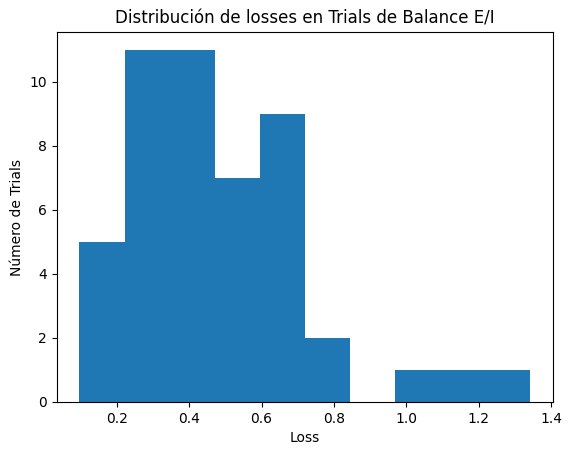

Text(0, 0.5, 'Número de Trials')

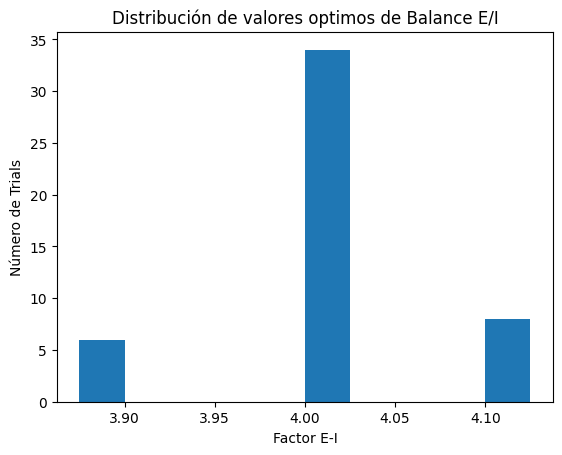

In [12]:
plt.hist(results_parallel['losses'])

plt.title("Distribución de losses en Trials de Balance E/I")
plt.xlabel("Loss")
plt.ylabel("Número de Trials")
plt.show()

plt.hist(results_parallel['best_balances'])

plt.title("Distribución de valores optimos de Balance E/I")
plt.xlabel("Factor E-I")
plt.ylabel("Número de Trials")

(array([1., 0., 0., 0., 0., 8., 0., 0., 0., 1.]),
 array([3.875, 3.9  , 3.925, 3.95 , 3.975, 4.   , 4.025, 4.05 , 4.075,
        4.1  , 4.125]),
 <BarContainer object of 10 artists>)

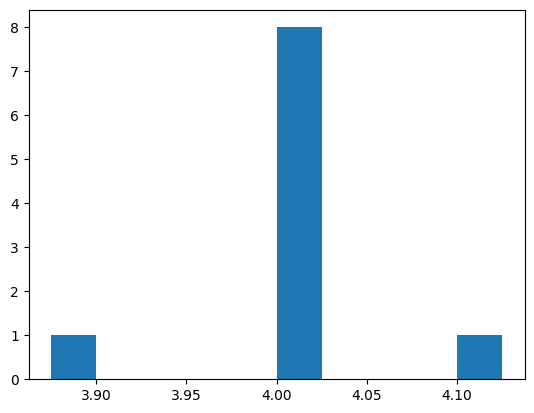

In [5]:
plt.hist(final_bests)

In [6]:
k_factor = 1.0
noise_int = 5.0*0.5 #5.1*0.85
noise_inh_factor = 0.45 #5
intra_delay = 0.0
p_intra = 0.1
Ni = 200
Ne = 800
time = 4000

# Simulation parameters
SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': time,
    'warmup_ms': 500
}


NETWORK_PARAMS = {
    'pop_A': {
        'Ne': Ne, 'Ni': Ni,
        'k_exc': k_factor, 'k_inh': k_factor*3.87,
        'noise_exc': 0.58, 
        'noise_inh': 0.35,
        'p_intra': 0.1, 
        'delay': 0.0,
        'rate_hz':1.64
    }
}

results, network, _ = run_iteration(NETWORK_PARAMS, SIM_CONFIG, trial, '2')

ei_stats = analyze_ei_balance(network, 'A', 800, 200)
print_ei_balance(ei_stats)


INFO     | __main__:run_iteration:13 - Simulation configured:
INFO     | __main__:run_iteration:14 -   Duration: 4000ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:44 - Network initialized with seeds: {'trial': 9, 'fixed_seed_A': 126, 'fixed_seed_B': 128, 'fixed_seed_common': 127, 'variable_base_A': 226, 'variable_base_B': 228, 'variable_base_common': 227, 'variable_common_current': 254, 'variable_A_current': 254, 'variable_B_current': 257}
INFO     | src.two_populations.model:_create_stimulus2:327 - PoissonGroup A: 100 sources @ 1.64Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:262 - Population A (PoissonInput): 800E/200I, 80122+20082 syn
INFO     | __main__:run_iteration:47 - 
INFO     | __main__:run_iteration:48 - SIMULATION COMPLETED
INFO     | __main__:run_iteration:49 - ==================================================
INFO     | __main__:run_iteration:50 - Population A: 27 spikes
INFO     | __main__:run_iteration:51 - R


BALANCE EXCITATORIO/INHIBITORIO

Métrica                             E neurons       I neurons
------------------------------------------------------------
Corriente Exc recibida (promedio)   40.124            40.180
Corriente Inh recibida (promedio)   38.948            39.030
Ratio E/I                           1.104            1.097

# inputs Exc (promedio)             80.1              80.4
# inputs Inh (promedio)             20.1              20.2



In [ ]:
from src.two_populations.metrics import analyze_simulation_results

from src.two_populations.plots.basic_plots import plot_raster_comparison, plot_raster_results

def get_mean_fr_per_celltype(results, pop='A', cell_type='I'):
    
    spike_monitor = results[pop]['spike_monitor']
        
    if cell_type == 'E':
        time_monitor = spike_monitor.t[spike_monitor.i <= 800]
        
    else:
        
        time_monitor = spike_monitor.t[spike_monitor.i > 800]


    spike_times = np.array(time_monitor/ms)

    T_total = 4000
    analysis_dt = 0.5
    smooth_window = 5
    N_neurons = 800 if cell_type == 'E' else 200

    if len(spike_times) == 0:
        max_time = T_total if T_total else 1000  # Default si no hay spikes
    else:
        max_time = T_total if T_total else np.max(spike_times)

    time_bins = np.arange(0, max_time + analysis_dt, analysis_dt)

    spike_counts, _ = np.histogram(spike_times, bins=time_bins)
    population_rate = spike_counts / (analysis_dt/1000) / N_neurons

    if smooth_window > 1:
        kernel = np.ones(smooth_window) / smooth_window
        population_rate = np.convolve(population_rate, kernel, mode='same')


    plt.plot(time_bins[:-1], np.nan_to_num(population_rate, nan=0.0, posinf=0.0, neginf=0.0))
    
    return np.mean(np.nan_to_num(population_rate, nan=0.0, posinf=0.0, neginf=0.0)[1000:])

def loss2(results):

    mean_I = get_mean_fr_per_celltype(results, 'A', cell_type='E')
    mean_E = get_mean_fr_per_celltype(results, 'A', cell_type='I')
    print(f"Mean I: {mean_I}, Mean_E: {mean_E}")
    return np.abs(mean_I-mean_E)

k_factor = 1.5
noise_int = 0.5 #5.1*0.85
#noise_inh_factor = 0.45 #5
intra_delay = 0.0
p_intra = 0.1
Ni = 200
Ne = 800
time = 4000

# Simulation parameters
SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': time,
    'warmup_ms': 500
}


final_bests = []
final_losses = []

for trial in range(1):
    
    print(f"Running trial: {trial}")
    
    best = 0.45
    best_loss = 100
    first = 0.1
    last = 1.0
    step = 0.2

    while best_loss > 0.5: # and step > 0.05:
        
        update = False
        mid = (last+first)/2
        
        if best_loss != 100:
            
            if best > mid:
                first = mid - step
            else:
                last = mid + step
                
            print(best, mid, first, last)
                
        input_balances = np.arange(first , last, step)
        step = step/2
        
        print(input_balances)
        
        print(best, best_loss, first, last, step)

        for i in range(len(input_balances)):
            
            # Network parameters
            NETWORK_PARAMS = {
                'pop_A': {
                    'Ne': Ne, 'Ni': Ni,
                    'k_exc': k_factor, 'k_inh': k_factor*1.96,
                    'noise_exc': noise_int, 'noise_inh': noise_int*input_balances[i],
                    'p_intra': p_intra, 'delay': intra_delay
                    # 'step': False,
                    # 'stim_start_ms':500.0, 'stim_duration_ms': 250,
                    # 'stim_base': 1.0, 
                    # 'stim_elevated': 1.0
                }
            }

            
            results, network, SIM_CONFIG = run_iteration(NETWORK_PARAMS, SIM_CONFIG, trial, '2')

            loss_value = loss2(results)
            
            plot_raster_results(results, 800, 1000, 500)
            plt.show()
            
            if loss_value < best_loss:
                best = input_balances[i]
                best_loss = loss_value
                update = True
                print(f'----- Update: {best} , {best_loss}')
                
            elif update:
                break
                
    final_bests.append(best)
    final_losses.append(best_loss)

final_bests, final_losses